In [67]:
from typing import Optional
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt 

# Generate data

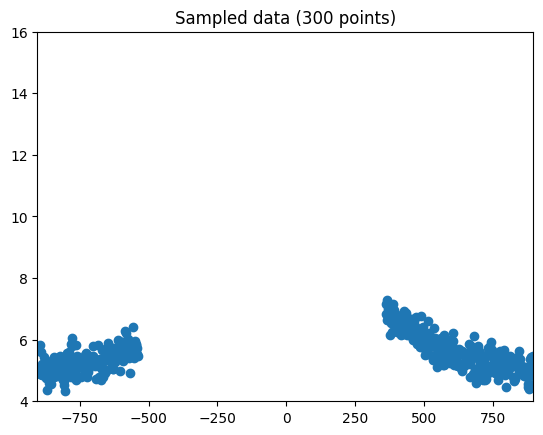

In [161]:

def sample_gauss_missing_center(n_samples = 1000, # true number of selected samples is n_samples*(1-per_missing)
                                sd_sampled :float = 3,
                                perc_missing : Optional[float] = 0.7,
                                perc_start_missing : Optional[float] = 0.2,
                                perc_end_missing : Optional[float] = 0.7, 
                                y_scale : float = 10,
                                y_shift : float = 5,
                                y_noise_scale :float= 0.3,
                                x_scale : float = 300,
                                x_shift : float = -2.5,
                                plot = True) -> tuple[np.ndarray]:
    """
    Sample Data from Gauss courve. Exclude data in the middle.
    Parameters:
        n_samples: number of initial samples. True number of selected samples is n_samples*(1-per_missing)
        sd_sampled: sampled range in standard deviations +- 
        perc_missing: where in the percetntual range should the missing window start
        perc_start_missing : where in the percetntual range should the missing window end
        perc_end_missing : what percentage of values should be missing
        y_scale : parameter of shape of sampled distribution
        y_shift : parameter of shape of sampled distribution
        y_noise_scale: parameter of noise distribution for y
        x_scale : parameter of shape of sampled distribution
        x_shift : parameter of shape of sampled distribution,
        plot : plot the sampled values
    """
    if sum([isinstance(i, float) for i in[perc_missing, perc_start_missing, perc_end_missing]]) < 2:
        Warning("Need to give 2 out of perc_missing, perc_start_missing, perc_end_missing")
    if perc_end_missing is None:
        perc_end_missing = perc_missing+perc_start_missing
    if perc_start_missing is None:
        perc_start_missing = perc_missing-perc_end_missing
    if perc_missing is None:
        perc_missing = perc_end_missing- perc_start_missing

    start_missing = int(n_samples*perc_start_missing)
    end_missing = int(n_samples*perc_end_missing)
    if end_missing > n_samples:
        Warning("Please select a smaller perc_missing or perc_start_missing. Now perc_end_missing is at {perc_end_missing}")
    x_unscaled = np.arange(n_samples)
    x_centered = (x_unscaled/n_samples) - 0.5
    x = x_centered*2*sd_sampled
    x_selected = np.concat([x[:start_missing], x[end_missing:]])
    y = norm.pdf(x_selected)*y_scale + y_shift

    x_new = (x_selected * x_scale) - x_shift

    # todo add noise to data
    rng = np.random.default_rng()
    y_noise = y_noise_scale * rng.normal(size=x_new.size)
    y_w_noise = y + y_noise 

    if plot:
        y_range = ((0*y_scale)+y_shift,(1*y_scale)+y_shift)
        y_plt_range = (y_range[0]-1, y_range[1]+1) 
        x_range = ((-sd_sampled*x_scale)+x_shift,(sd_sampled*x_scale)+x_shift)
        x_plt_range = (x_range[0]-1, x_range[1]+1) 
        n_true_samped = int((1-perc_missing)*n_samples)


        plt.scatter(x_new, y_w_noise)
        plt.title(f"Sampled data ({n_true_samped} points)")
        plt.ylim(y_plt_range)
        plt.xlim(x_plt_range)
        plt.show()
    
    return x_new, y_w_noise, x_selected, y 

x, y, x_unscaled, y_no_noise = sample_gauss_missing_center()

# Estimate parameters

[-297.15974845   -4.68342809   10.28448679    5.02898016]


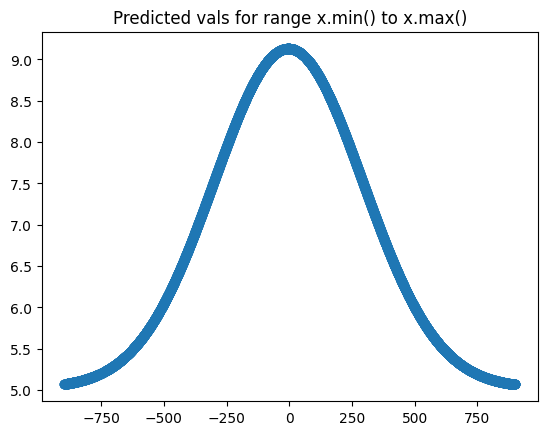

In [160]:
def my_norm(x, x_scale, x_shift, y_scale, y_shift):
    "Redefine parameters to norm.pdf."
    x_unscaled = (x-x_scale)/x_shift
    return (norm.pdf(x_unscaled)*y_scale) + y_shift


# will fail without some guidance guess (can change if have better guess)
guess_for_x_sd =  np.sqrt(sum(np.array([x.mean() - x.min(), x.mean() - x.max()])**2))
guess_for_mean = x.mean()
guess_for_y_scale = y.max() - y.min()
guess_for_y_offset = y.min()
inital_guess = [guess_for_x_sd, guess_for_mean, guess_for_y_scale, guess_for_y_offset]

#fit
params, pcov = curve_fit(f = my_norm, xdata =  x, ydata =  y, p0 = inital_guess)
print(params) 

# Predict Values

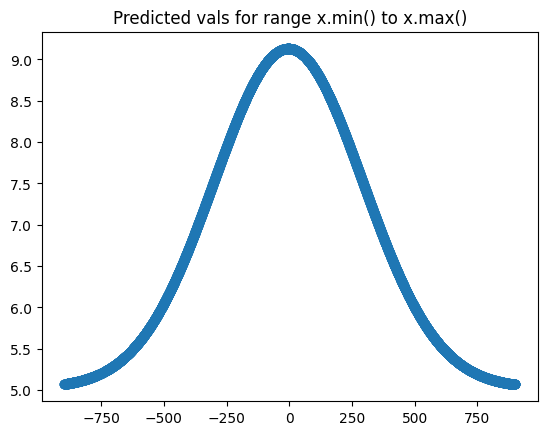

In [162]:
x_pred = np.arange(start= x.min(), stop = x.max(), step= 0.3) # put x values for which to predict here 
y_pred = my_norm(x_pred,params[0], params[1], params[2], params[3]) 
plt.scatter(x_pred, y_pred)
plt.title("Predicted vals for range x.min() to x.max()")
plt.show()

#save
pd.DataFrame({"x": x_pred, "y" : y_pred}).to_csv("predicted_data.csv")